In [14]:
# for cleaning up after tests
import os
dir = "../calibrate/stacks/"
for f in os.listdir(dir):
    if ".bin" in f:
        os.remove(os.path.join(dir, f))

In [ ]:
import csv_relations
data_dirs = []
dir_files = Dir(root, "test")
dir_files.bag = os.path.join(root, "rtk-co-locate.bag")
dir_files.clicks = os.path.join(root, "rtk-clicks.csv")
data_dirs.append(dir_files)

proc_click = []

origin = None

data_dirs[0].clicks = '../calibrate/rtk-click.csv'

# go over the CSVs
for a in data_dirs:
    C = csv_relations.CSVAugmented(a.path)
    C.csv_read()
    C.done()
    proc_click.append(C)

In [15]:
%load_ext autoreload
%autoreload 2

from banners import *
# import csv_relations
import os
root = "../calibrate"
# get all dirs with data and order by date
'''
data_dirs = []
for dd in os.listdir(root):
    d = os.path.join(root, dd)
    print(d)
    if os.path.isdir(d):
        dir_files = Dir(d, dd)
        for f in os.listdir(d):
            if ".bag" in f:
                dir_files.bag = os.path.join(d, f)
            if ".csv" in f:
                dir_files.clicks = os.path.join(d, f)
        data_dirs.append(dir_files)
'''


print(data_dirs)

TOPICS = ['/current_pose', '/cam0/nv12_decode_result', '/cam1/nv12_decode_result', '/therm/image_raw_throttle']

processed_data = []

# process each bag
for a in data_dirs:
    cc = CameraCombo(a)
    bag = rosbag.Bag(a.bag)
    for topic, msg, t in bag.read_messages(TOPICS):
        # print(topic)
        # stack 3 images together
        if topic == '/therm/image_raw_throttle':
            # print("thermal")
            cc.flir = msg
        if topic == '/cam1/nv12_decode_result':
            # print("rgb")
            cc.rgb = msg

        if topic == '/cam0/nv12_decode_result':
            # print("noir")
            cc.noir = msg
        if topic == "/current_pose":
            # print("stacking")
            cc.pose = msg.pose.pose
            cc.stack(t)
    processed_data.append(cc)
    cc.done()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Dir(path='../calibrate', date='test', bag='../calibrate/rtk-co-locate.bag', clicks='../calibrate/rtk-clicks.csv')]
[5.83839677e+05 4.09057676e+06 2.29030644e+01 1.00000000e+00]
[5.83817309e+05 4.09056819e+06 1.09349280e+00 1.00000000e+00]
[5.83828487e+05 4.09057247e+06 1.19918133e+01 1.00000000e+00]
[5.83840750e+05 4.09057509e+06 2.35429184e+01 1.00000000e+00]
[5.83816671e+05 4.09057070e+06 2.32211389e+00 1.00000000e+00]
[5.83828704e+05 4.09057289e+06 1.29258361e+01 1.00000000e+00]
[5.83840753e+05 4.09057508e+06 2.35449010e+01 1.00000000e+00]
[5.83816667e+05 4.09057070e+06 2.32771853e+00 1.00000000e+00]
[5.83828703e+05 4.09057289e+06 1.29296293e+01 1.00000000e+00]
[5.83841660e+05 4.09057346e+06 2.38743253e+01 1.00000000e+00]
[5.83816291e+05 4.09057284e+06 3.73805565e+00 1.00000000e+00]
[5.83828968e+05 4.09057315e+06 1.37994910e+01 1.00000000e+00]
[5.83841667e+05 4.09057345e+06 2.38753190e+01 1.0000

0      583839.677450
1      583840.750066
2      583840.752790
3      583841.660004
4      583841.667018
           ...      
855    583836.899073
856    583836.908091
857    583836.909041
858    583836.931912
859    583836.932528
Name: xmax, Length: 860, dtype: float64

Series([], Name: save_loc, dtype: object)


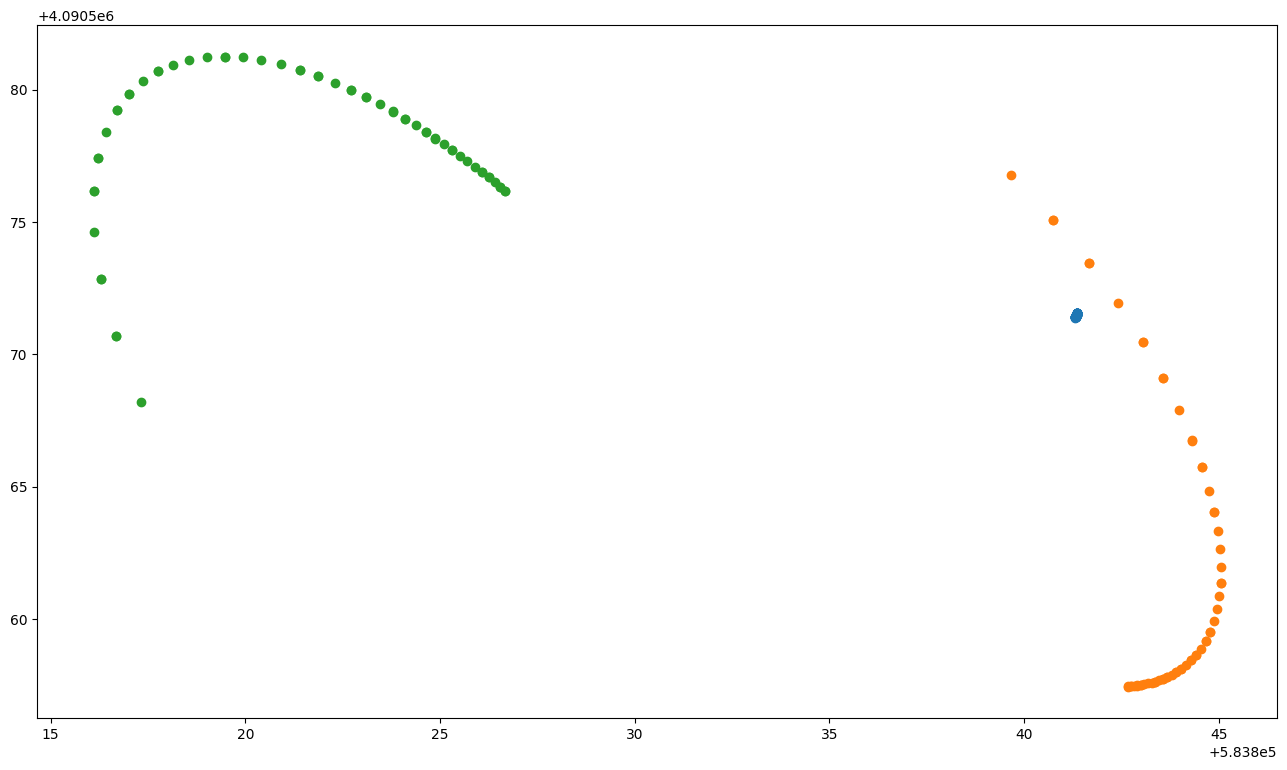

In [29]:
# plot things
import matplotlib.pyplot as plt
from matplotlib import patches

to_see = 60


fig, ax = plt.subplots(figsize=(16, 9))

# ===============plot trajectory===============
# get x and y of trajectory
p_x = processed_data[0].parsed.pose.map(lambda x: x[0, 3])
p_y = processed_data[0].parsed.pose.map(lambda x: x[1, 3])
ax.scatter(p_x[:to_see], p_y[:to_see])

# ===================plot vision cones======================
xmaxs = processed_data[0].parsed.xmax.tolist()
ymaxs = processed_data[0].parsed.ymax.tolist()
xmins = processed_data[0].parsed.xmin.tolist()
ymins = processed_data[0].parsed.ymin.tolist()
widths = np.asarray(xmaxs) - np.asarray(processed_data[0].parsed.xmin.tolist())
heights = np.asarray(ymaxs) - np.asarray(processed_data[0].parsed.ymin.tolist())
ax.scatter(xmaxs[:to_see], ymaxs[:to_see])
ax.scatter(xmins[:to_see], ymins[:to_see])



In [ ]:
import matplotlib.patches as patches
from cv_bridge import CvBridge
from sensor_msgs.msg import Image

bridge = CvBridge()

# back projection time
def pretty_image(point, image, dataframe, img_type):
    file = open(image, 'rb')
    imgs = pickle.load(file)
    row = dataframe.loc[dataframe['save_loc'] == image]
    pose = row.pose.item()
    # subtract xmax and ymax from pt then use K to project back
    x = pt[0] - pose[0, 3]
    y = pt[1] - pose[1, 3]
    print(x, y)
    # print(type(list(imgs['rgb'].data)))
    fig, ax = plt.subplots()
    if img_type == 'flir':
        img = bridge.imgmsg_to_cv2(imgs[img_type])
        K = flir_K
    else:
        img = np.asarray(list(imgs[img_type].data)[:1080*1920]).reshape((1080, 1920))
        if img_type == 'noir':
            K = noir_K
        else:
            K = rbg_K

    l = np.array([x, y, 10]).T
    # print(l)
    xy = K@l
    print(xy)
    xy = xy / xy[2]
    x = xy[0]
    y = xy[1]
    # print(img.shape)
    ax.imshow(img)
    rect = patches.Rectangle((x, y), 40, 30, linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect)

    plt.show()

def demo_wrapper(c, r, img_type):
    click_to_use = c
    relation_to_use = r
    pt = [proc_click[0].related.x[click_to_use], proc_click[0].related.y[click_to_use]]
    imgs = proc_click[0].related.relevant[0][relation_to_use]
    pretty_image(pt, imgs, processed_data[0].parsed, img_type)

demo_wrapper(0, 10, 'rgb')
# demo_wrapper(1, 10)

In [ ]:
for i in range(5):
    demo_wrapper(45, i, 'flir')